In [16]:
import nltk
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
from datasets import load_dataset
import pandas as pd
import csv
import sentencepiece
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from rouge_score import rouge_scorer
import csv

In [4]:
print("CUDA Available:", torch.cuda.is_available())
# Get the name of the CUDA device
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))

CUDA Available: True
CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [12]:
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
# Function to generate summary
def generate_summary(input_text, max_length=5000):
    input_text = "summarize: " + input_text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=8192, truncation=True)
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1)
    summary = tokenizer.decode(output[0], skip_special_tokens=False)
    return summary

In [7]:
#Initialize the dataset
multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20230518")
validation = list(multi_lexsum["validation"])

In [8]:
#importing generated summary rogue score
generated_score = pd.read_csv("rouge_scores_openai_validation_complete.csv")
case_list = generated_score["Case ID"]

In [9]:
#get refrence summary
def get_summary_long(target_id):
    # Iterate over each entry in the 'validation' list
    for entry in validation:
        # Check if the 'id' key in the entry matches the 'target_id'
        if entry['id'] == target_id:
            # Return the long summary from the matching entry
            return entry['summary/long']
    # Optional: Return a message if no matching entry is found
    return "No summary found for the given ID."

In [14]:
#get full text
def get_full_text(target_id):
    # Iterate over each entry in the 'validation' list
    for entry in validation:
        # Check if the 'id' key in the entry matches the 'target_id'
        if entry['id'] == target_id:
            # Return the long summary from the matching entry
            return entry['sources']
    # Optional: Return a message if no matching entry is found
    return "No summary found for the given ID."

In [17]:
def process(iteration, csv_file_path='t5_summary_rogue.csv'):
    refrence_summary = get_summary_long(case_list[iteration])
    #generate summary using bert
    generated_summary = generate_summary(str(get_full_text(case_list[iteration])))

    # print(refrence_summary)
    # print(generated_summary)

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    score = scorer.score(generated_summary, refrence_summary )

    # print(score['rouge1'].precision)
    # print(score['rouge1'].recall)
    # print(score['rouge1'].fmeasure)
    # print(score['rouge2'].precision)
    # print(score['rouge2'].recall)
    # print(score['rouge2'].fmeasure)
    # print(score['rougeL'].precision)
    # print(score['rougeL'].recall)
    # print(score['rougeL'].fmeasure)

    with open(csv_file_path, 'a', newline='') as csvfile:
        fieldnames = [
            'Case_ID', 'refrence_summary','generated_summary',
            'ROUGE-1_Precision', 'ROUGE-1_Recall', 'ROUGE-1_F1',
            'ROUGE-2_Precision', 'ROUGE-2_Recall', 'ROUGE-2_F1',
            'ROUGE-L_Precision', 'ROUGE-L_Recall', 'ROUGE-L_F1',
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        data = {
        'Case_ID': case_list[iteration],
        'refrence_summary': refrence_summary,
        'generated_summary': generated_summary,
        'ROUGE-1_Precision': round(score['rouge1'].precision, 4),
        'ROUGE-1_Recall': round(score['rouge1'].recall, 4),
        'ROUGE-1_F1': round(score['rouge1'].fmeasure, 4),
        'ROUGE-2_Precision': round(score['rouge2'].precision, 4),
        'ROUGE-2_Recall': round(score['rouge2'].recall, 4),
        'ROUGE-2_F1': round(score['rouge2'].fmeasure, 4),
        'ROUGE-L_Precision': round(score['rougeL'].precision, 4),
        'ROUGE-L_Recall': round(score['rougeL'].recall, 4),
        'ROUGE-L_F1': round(score['rougeL'].fmeasure, 4),
        }
        # print(data)  # Debugging line to check the output
        writer.writerow(data)

In [18]:
# process(0)

In [ ]:
#run the process for set number of iteration
for i in range(0, len(case_list)):
    print(i)
    process(i)

In [20]:
t5_data = pd.read_csv("t5_summary_rogue.csv")
t5_data

,Case_ID,refrence_summary,generated_summary,ROUGE-1_Precision,ROUGE-1_Recall,ROUGE-1_F1,ROUGE-2_Precision,ROUGE-2_Recall,ROUGE-2_F1,ROUGE-L_Precision,ROUGE-L_Recall,ROUGE-L_F1
0,EE-MO-0105,"On January 23, 2004, Plaintiff filed an amende...",<pad> a federal judge has ruled that a class a...,0.0460,0.4717,0.0838,0.0147,0.1538,0.0269,0.0312,0.3208,0.0570
1,EE-MI-0138,"In September 2003, the Detroit office of the E...",<pad> a federal judge has ruled that a'reasona...,0.0500,0.1892,0.0791,0.0144,0.0556,0.0229,0.0429,0.1622,0.0678
2,EE-FL-0124,"On May 10, 2002, the United States filed a law...",<pad> Defendant will maintain a copy of the tr...,0.0649,0.5556,0.1163,0.0130,0.1132,0.0233,0.0411,0.3519,0.0736
3,DR-TX-0003,"On April 25, 2016, three individuals that were...",<pad> a motion to dismiss a class action filed...,0.0544,0.5490,0.0989,0.0078,0.0800,0.0142,0.0350,0.3529,0.0636
4,EE-GA-0095,"In March 2001, the EEOC district office in Atl...","<pad> Defendant, a 'protected group', filed a ...",0.1656,0.5200,0.2512,0.0449,0.1429,0.0683,0.0955,0.3000,0.1449
...,...,...,...,...,...,...,...,...,...,...,...,...
246,EE-NY-0146,"In January 2004, the New York District Office ...",<pad> Defendants SPS/PPMC and JAMESTOWN CONTAI...,0.0683,0.4545,0.1187,0.0068,0.0465,0.0119,0.0546,0.3636,0.0950
247,EE-NC-0086,The EEOC's Charlotte office filed this suit in...,<pad> Defendant's actions were deemed to be in...,0.1159,0.2424,0.1569,0.0000,0.0000,0.0000,0.0942,0.1970,0.1275
248,CJ-CO-0004,"On November 7, 2017, a former pretrial detaine...",<pad> a judicial review of the 'pretrial servi...,0.0821,0.7042,0.1471,0.0312,0.2714,0.0560,0.0591,0.5070,0.1059
249,EE-LA-0028,"In August 1998, the EEOC district office in Ne...","<pad> 'i'm a black female,''''''''''''''''''''...",0.0190,0.4286,0.0364,0.0000,0.0000,0.0000,0.0127,0.2857,0.0242


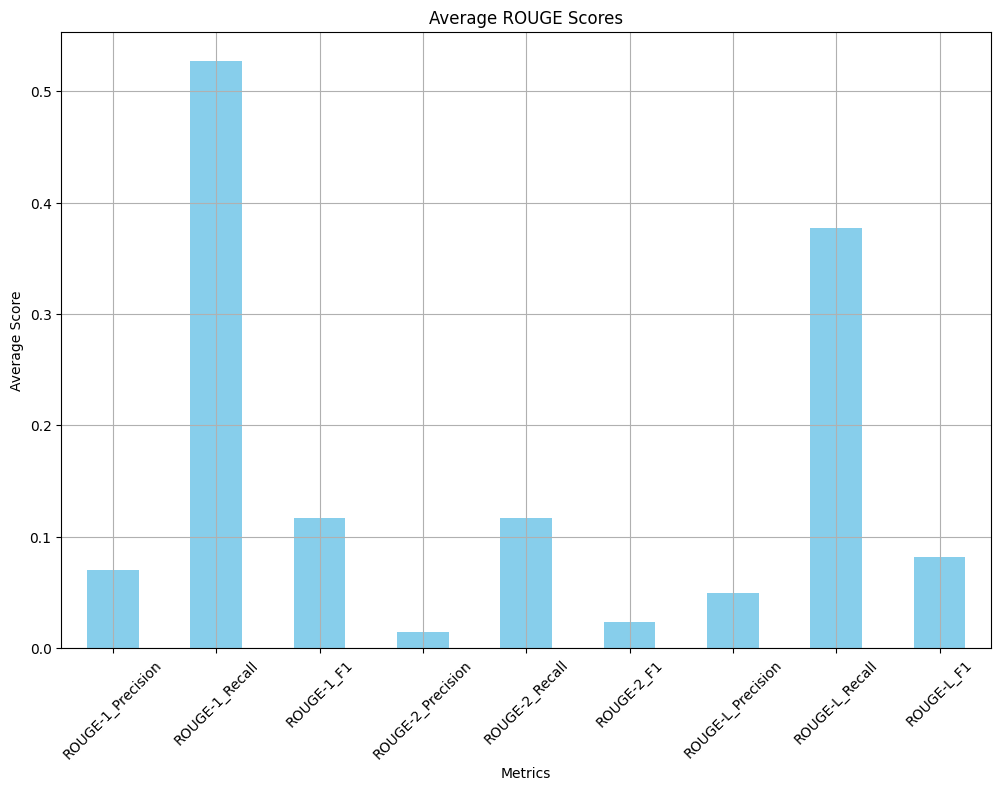

In [21]:
import matplotlib.pyplot as plt

# Calculate mean values for the specified columns
mean_values = t5_data[['ROUGE-1_Precision', 'ROUGE-1_Recall', 'ROUGE-1_F1', 
                               'ROUGE-2_Precision', 'ROUGE-2_Recall', 'ROUGE-2_F1', 
                               'ROUGE-L_Precision', 'ROUGE-L_Recall', 'ROUGE-L_F1']].mean()

# Plotting the bar graph
plt.figure(figsize=(12, 8))
mean_values.plot(kind='bar', color='skyblue')
plt.title('Average ROUGE Scores')
plt.xlabel('Metrics')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()